In [5]:
import os
import pandas as pd
import random
import logging
from ecg_utils import  get_hea_file_paths,load_ecg,preprocess_data, compute_snr

# Define hyperparameters for the code 
computer = 1         # computer = 1 : running on computer, computer = 0: running on cluster 


# Define paths based on environment
if computer:
    data_directory_path = "/Users/sinahassannia/Desktop/ptbxl_dataset/records500"
    core_path_results = "/Users/sinahassannia/Documents/emory/research/ecg_recons/results"
    metadata_csv_path = "/Users/sinahassannia/Desktop/ptbxl_dataset/ptbxl_database.csv"
else:
    data_directory_path = "/labs/samenilab/team/sina_hassannia/data/ptbxl/physionet.org/files/ptb-xl/1.0.3/records500/"
    core_path_results = "/labs/samenilab/team/sina_hassannia/codes/ecg_sep/ecg_sepration/results/"
    metadata_csv_path = "/labs/samenilab/team/sina_hassannia/data/ptbxl/physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv"
    fiducial_path = "/labs/samenilab/team/sina_hassannia/active_projects/ecg_sepration/results/fiducial_results/ecg_fiducials_ptbxl_lead II.csv"

leads = ["I", "II", "V1", "V2", "V3", "V4", "V5", "V6"]

# Load metadata 
metadata_df = pd.read_csv(metadata_csv_path)

# Get and split data
hea_files = get_hea_file_paths(data_directory_path)
random.seed(42)
random.shuffle(hea_files)

split_idx = int(0.8 * len(hea_files))
record_paths_train = hea_files[:split_idx]
record_paths_val = hea_files[split_idx:]

# Limit dataset size for computer 
summry = True
if summry == True:
    if  computer:  
        record_paths_train = record_paths_train[:1000]
        record_paths_val = record_paths_val[:1000]

print(f"Total records: {len(hea_files)}")
print(f"Training records: {len(record_paths_train)}")
print(f"Validation records: {len(record_paths_val)}")

Total records: 21837
Training records: 1000
Validation records: 1000


In [6]:
# kalman_fir.py

import numpy as np

def build_regressors(x, order):
    """
    Build regressor matrix for an FIR of given order using zero padding.
    Each row corresponds to one original sample.

    Returns
    -------
    Phi : (N, order + 1) matrix
        Each row t is [x_t, x_{t-1}, ..., x_{t-order}]
        with x_k = 0 for k < 0
    y_idx_start : int
        Index in the original signal where the aligned output should start.
    """
    x = np.asarray(x).flatten()
    N = len(x)

    # zero-pad on the left
    x_pad = np.pad(x, (order, 0), mode='constant')

    Phi = np.zeros((N, order + 1), dtype=float)

    for t in range(N):
        Phi[t, :] = x_pad[t + order - np.arange(order + 1)]

    return Phi, 0






def kalman_adaptive_fir(x, y, order=4, q_var=1e-6, r_var=1e-3,
                        h0=None, P0=None, eps_S=1e-12):
    """
    Kalman filter for time-varying FIR: y_hat_t = h_t^T * phi_t

    State (random walk):
        h_{t+1} = h_t + w_t,   w_t ~ N(0, Q), Q = q_var * I

    Measurement:
        y_t = phi_t^T h_t + v_t,  v_t ~ N(0, R), R = r_var

    Uses zero-padded regressors so predictions exist for all samples.

    Parameters
    ----------
    x : array, shape (N,)
        Input signal
    y : array, shape (N,)
        Target signal
    order : int
        FIR order q (state size M = q+1)
    q_var : float
        Process noise variance (Q = q_var * I)
    r_var : float
        Measurement noise variance (scalar R)
    h0 : array-like, optional, shape (M,)
        Initial coefficient state
    P0 : array-like, optional, shape (M,M)
        Initial covariance
    eps_S : float
        Small floor for innovation variance S

    Returns
    -------
    y_hat_full : np.ndarray, shape (N,)
        Reconstructed y aligned with original indices
    h_hist : np.ndarray, shape (N, M)
        History of coefficient estimates
    residuals : np.ndarray, shape (N,)
        y_t - y_pred_t at each time
    """
    x = np.asarray(x).flatten()
    y = np.asarray(y).flatten()
    N = len(y)
    if len(x) != N:
        raise ValueError("x and y must have the same length")
    if N == 0:
        raise ValueError("Empty signals.")
    if order < 0:
        raise ValueError("order must be >= 0")

    Phi, offset = build_regressors(x, order)  # offset == 0 with zero-padding
    M = order + 1
    T = Phi.shape[0]  # == N

    # Initialize state and covariance
    h = np.zeros(M, dtype=float) if h0 is None else np.asarray(h0, dtype=float).copy()
    P = (np.eye(M, dtype=float) * 1.0) if P0 is None else np.asarray(P0, dtype=float).copy()

    Q = np.eye(M, dtype=float) * float(q_var)
    R = float(r_var)

    y_hat_segment = np.zeros(T, dtype=float)
    h_hist = np.zeros((T, M), dtype=float)
    residuals = np.zeros(T, dtype=float)

    I_M = np.eye(M, dtype=float)

    for t in range(T):
        phi_t = Phi[t, :]          # (M,)
        y_t = y[t + offset]        # offset = 0

        # ---- Prediction step ----
        h_pred = h                 # random walk
        P_pred = P + Q

        # ---- Measurement prediction ----
        y_pred = float(phi_t @ h_pred)

        # ---- Innovation ----
        innov = float(y_t - y_pred)
        S = float(phi_t @ P_pred @ phi_t + R)
        if S <= eps_S:
            S = eps_S

        # ---- Kalman gain ----
        K = (P_pred @ phi_t) / S   # (M,)

        # ---- Update step ----
        h = h_pred + K * innov

        # Joseph-form covariance update (numerically stable)
        KH = np.outer(K, phi_t)
        P = (I_M - KH) @ P_pred @ (I_M - KH).T + R * np.outer(K, K)

        # Store
        y_hat_segment[t] = float(phi_t @ h)
        h_hist[t, :] = h
        residuals[t] = innov

    y_hat_full = y_hat_segment.copy()
    return y_hat_full, h_hist, residuals


In [7]:
import numpy as np

def estimate_Q_R_on_dataset(record_paths,
                            order=4,
                            q_var_init=1e-6,
                            r_var_init=1e-3,
                            leads=("I", "II"),
                            max_records=None,
                            n_iters=2,
                            burn_in=None,
                            q_floor=1e-12,
                            r_floor=1e-12):
    """
    Estimate global q_var and r_var from a dataset (EM-like).

    Notes (important with zero-padding):
    - Excludes an initial burn-in region to avoid bias from padded regressors
      and Kalman transient.
    - Uses only finite residuals / coefficient diffs.
    - Applies floors to prevent collapse.

    Returns
    -------
    q_var_est, r_var_est
    """

    if max_records is not None:
        record_paths = record_paths[:max_records]

    target_lead, input_lead = leads
    q_var = float(q_var_init)
    r_var = float(r_var_init)

    # Default burn-in: at least 'order', usually a bit more for settling
    if burn_in is None:
        burn_in = max(order, 5 * order)

    for it in range(n_iters):
        print(f"\n=== Iteration {it+1}/{n_iters} ===")
        sum_resid2 = 0.0
        count_resid = 0

        sum_dh2 = 0.0
        count_dh = 0

        for idx, path in enumerate(record_paths):
            try:
                signal, record = load_ecg(path, selected_leads=[target_lead, input_lead])
                fs = record.fs
                signal = preprocess_data(signal, fs)

                y = signal[:, 0]  # target
                x = signal[:, 1]  # input

                y_hat, h_hist, residuals = kalman_adaptive_fir(
                    x=x, y=y, order=order, q_var=q_var, r_var=r_var
                )

                # ---- Residual-based R update ----
                # With zero-padding, residuals is length N; ignore burn-in.
                resid_seg = residuals[burn_in:]
                mask_r = np.isfinite(resid_seg)
                if np.any(mask_r):
                    sum_resid2 += float(np.sum(resid_seg[mask_r] ** 2))
                    count_resid += int(np.sum(mask_r))

                # ---- Coefficient-diff-based Q update ----
                # Ignore burn-in here too (diff reduces length by 1).
                if h_hist.shape[0] > burn_in + 1:
                    h_seg = h_hist[burn_in:, :]
                    dh = np.diff(h_seg, axis=0)  # (T-1, M)
                    mask_q = np.isfinite(dh)
                    if np.any(mask_q):
                        sum_dh2 += float(np.sum((dh[mask_q]) ** 2))
                        count_dh += int(np.sum(mask_q))

            except Exception as e:
                print(f"Skipping {path} due to error: {e}")
                continue

            if (idx + 1) % 50 == 0:
                print(f"  Processed {idx+1}/{len(record_paths)} records")

        # Update R and Q using global averages + floors
        if count_resid > 0:
            r_var = max(sum_resid2 / count_resid, r_floor)
        if count_dh > 0:
            q_var = max(sum_dh2 / count_dh, q_floor)

        print(f"  Updated r_var = {r_var:.3e}, q_var = {q_var:.3e}")

    return q_var, r_var




In [4]:


import numpy as np
import pandas as pd
from itertools import product

def snr_table_kalman(
    record_paths_val,
    leads,
    order=4,
    q_var_init=1e-6,
    r_var_init=1e-3,
    max_records=5,
    n_iters=2,
    burn_in=0,
    verbose=True,
):
    """
    Returns:
      F_mean: pd.DataFrame  (rows = target i, cols = source j) mean SNR across records
      F_std:  pd.DataFrame  std  SNR across records
      per_pair_snrs: dict[(i,j)] -> list of SNRs (one per record, may be shorter if failures)
    """
    F_mean = pd.DataFrame(np.nan, index=leads, columns=leads, dtype=float)
    F_std  = pd.DataFrame(np.nan, index=leads, columns=leads, dtype=float)
    per_pair_snrs = {}

    for i, j in product(leads, leads):
        if i == j:
            continue  # usually skip self->self; set if you want

        if verbose:
            print(f"\n=== Estimating Q/R for pair: target={i} from source={j} (order={order}) ===")

        # 1) Estimate (global across dataset) Q/R for this pair
        q_est, r_est = estimate_Q_R_on_dataset(
            record_paths=record_paths_val,
            order=order,
            q_var_init=q_var_init,
            r_var_init=r_var_init,
            leads=(i, j),
            max_records=max_records,
            n_iters=n_iters,
            burn_in=burn_in,
        )
        q_var, r_var = q_est, r_est

        # 2) Evaluate SNR across validation records
        snrs_val = []
        for path in record_paths_val:
            signal, record = load_ecg(path, selected_leads=[i, j])
            fs = record.fs
            signal = preprocess_data(signal, fs)

            # IMPORTANT: keep mapping consistent with your original code:
            # lead_I   = target (to reconstruct)  = i
            # lead_II  = source (input)           = j
            #
            # load_ecg returns signal with columns in the same order as selected_leads,
            # i.e. signal[:,0] -> i, signal[:,1] -> j
            target = signal[:, 0]  # i
            source = signal[:, 1]  # j

            y_hat, h_hist, residuals = kalman_adaptive_fir(
                x=source,
                y=target,
                order=order,
                q_var=q_var,
                r_var=r_var
            )

            valid = ~np.isnan(y_hat)
            if np.any(valid):
                snr_val = compute_snr(target[valid], y_hat[valid])
                snrs_val.append(snr_val)

        per_pair_snrs[(i, j)] = snrs_val
        if len(snrs_val) > 0:
            F_mean.loc[i, j] = float(np.mean(snrs_val))
            F_std.loc[i, j]  = float(np.std(snrs_val, ddof=1)) if len(snrs_val) > 1 else 0.0

        if verbose:
            print(f"Pair ({i} <- {j}): mean SNR={F_mean.loc[i,j]:.4f} over n={len(snrs_val)} records; q={q_var}, r={r_var}")

    return F_mean, F_std, per_pair_snrs


# Example usage:
leads = ["I","II","V1","V2","V3","V4","V5","V6"]

F_mean, F_std, per_pair_snrs = snr_table_kalman(
    record_paths_val=record_paths_val,
    leads=leads,
    order=4,
    q_var_init=1e-6,
    r_var_init=1e-3,
    max_records=1000,
    n_iters=1,
    burn_in=0,
    verbose=True
)

print("\nLead x Lead mean SNR table (target rows, source cols):")
print(F_mean)

F_mean.to_csv("snr_table_mean.csv", index=True)
F_std.to_csv("snr_table_std.csv", index=True)




=== Estimating Q/R for pair: target=I from source=II (order=4) ===

=== Iteration 1/1 ===
  Updated r_var = 1.713e-02, q_var = 1.749e-03
Pair (I <- II): mean SNR=10.7467 over n=1000 records; q=0.001749069499756868, r=0.017127727628949246

=== Estimating Q/R for pair: target=I from source=V1 (order=4) ===

=== Iteration 1/1 ===
  Updated r_var = 2.133e-01, q_var = 1.939e-03
Pair (I <- V1): mean SNR=7.5332 over n=1000 records; q=0.0019387524989614299, r=0.21331849719158036

=== Estimating Q/R for pair: target=I from source=V2 (order=4) ===

=== Iteration 1/1 ===
  Updated r_var = 1.973e-01, q_var = 4.735e-03
Pair (I <- V2): mean SNR=7.7299 over n=1000 records; q=0.004735403157917994, r=0.19729149027202406

=== Estimating Q/R for pair: target=I from source=V3 (order=4) ===

=== Iteration 1/1 ===
  Updated r_var = 2.085e-01, q_var = 2.501e-03
Pair (I <- V3): mean SNR=7.4807 over n=1000 records; q=0.002500650970859373, r=0.20846172091626217

=== Estimating Q/R for pair: target=I from sourc


=== Iteration 1/2 ===
  Processed 50/1000 records
  Processed 100/1000 records
  Processed 150/1000 records
  Processed 200/1000 records
  Processed 250/1000 records
  Processed 300/1000 records
  Processed 350/1000 records
  Processed 400/1000 records
  Processed 450/1000 records
  Processed 500/1000 records
  Processed 550/1000 records
  Processed 600/1000 records
  Processed 650/1000 records
  Processed 700/1000 records
  Processed 750/1000 records
  Processed 800/1000 records
  Processed 850/1000 records
  Processed 900/1000 records
  Processed 950/1000 records
  Processed 1000/1000 records
  Updated r_var = 1.337e-02, q_var = 1.300e-03

=== Iteration 2/2 ===
  Processed 50/1000 records
  Processed 100/1000 records
  Processed 150/1000 records
  Processed 200/1000 records
  Processed 250/1000 records
  Processed 300/1000 records
  Processed 350/1000 records
  Processed 400/1000 records
  Processed 450/1000 records
  Processed 500/1000 records
  Processed 550/1000 records
  Process

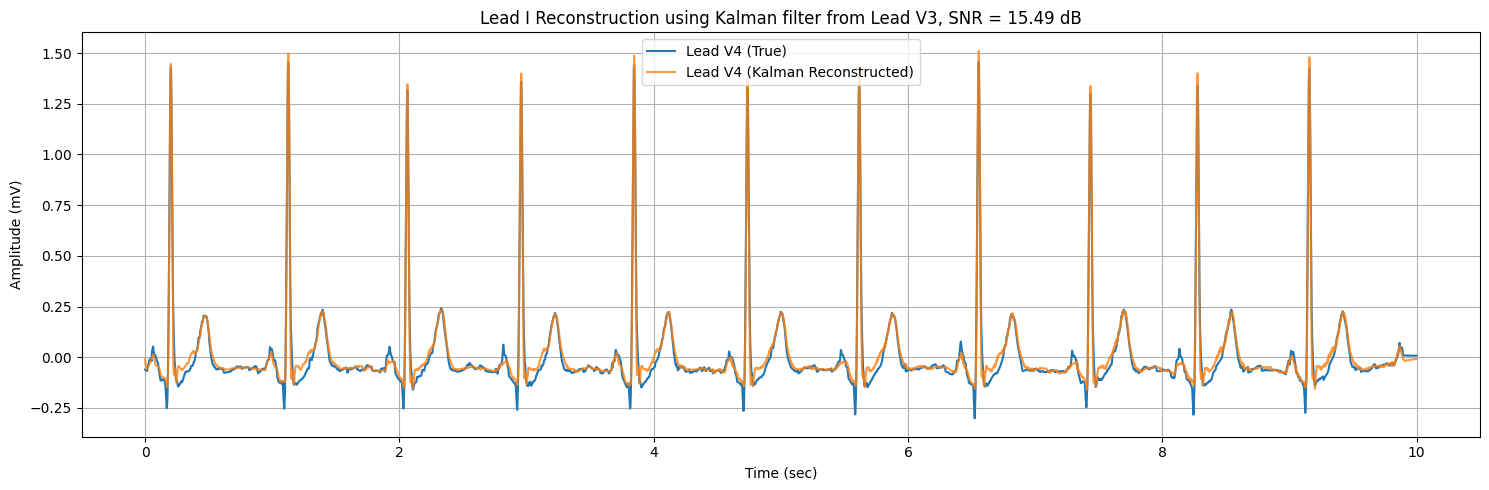

SNR for this record = 15.49 dB


In [13]:
import matplotlib.pyplot as plt
order = 4
q_est, r_est = estimate_Q_R_on_dataset(
    record_paths=record_paths_val,
    order=order,
    q_var_init=1e-6,
    r_var_init=1e-3,
    leads=("I", "V4"),
    max_records=5000,
    n_iters=2,
    burn_in=0   # or e.g. int(1.0*fs) if you prefer 1 second
)
q_var = q_est
r_var = r_est
record_path = record_paths_val[443]   # choose ANY record
print("Visualizing record:", record_path)

selected_leads=["I", "V4"]
signal, record = load_ecg(record_path, selected_leads=selected_leads)
fs = record.fs

signal = preprocess_data(signal, fs)

target = signal[:, 0]  # i
source = signal[:, 1]  # j

y_hat, h_hist, residuals = kalman_adaptive_fir(
    x=source,
    y=target,
    order=order,
    q_var=q_var,
    r_var=r_var
)

valid = ~np.isnan(y_hat)
snr_val = compute_snr(target[valid], y_hat[valid])
print(f"SNR for this record = {snr_val:.2f} dB")
t = np.arange(len(target)) / fs

plt.figure(figsize=(15,5))
plt.plot(t, target, label=f"Lead {selected_leads[1]} (True)", linewidth=1.5)
plt.plot(t, y_hat, label=f"Lead {selected_leads[1]} (Kalman Reconstructed)", alpha=0.8)
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude (mV)")
plt.title(f"Lead {selected_leads[0]} Reconstruction using Kalman filter from Lead V3, SNR = {snr_val:.2f} dB")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from ecg_utils import compute_snr

snr_val = compute_snr(target, y_hat)
print(f"SNR for this record = {snr_val:.2f} dB")




In [ ]:
# import matplotlib.pyplot as plt

# import numpy as np

# def add_awgn_snr(x, snr_db, rng=None):
#     """
#     Add zero-mean white Gaussian noise to x to obtain a given SNR (in dB).
#     SNR is defined as 10*log10(P_signal / P_noise).
#     """
#     x = np.asarray(x)
#     if rng is None:
#         rng = np.random.default_rng(0)   # fixed seed for reproducibility

#     sig_power = np.mean(x**2)
#     snr_linear = 10**(snr_db / 10.0)
#     noise_power = sig_power / snr_linear
#     noise_std = np.sqrt(noise_power)

#     noise = rng.normal(0.0, noise_std, size=x.shape)
#     x_noisy = x + noise
#     return x_noisy, noise


# order = 4
# q_var = q_est
# r_var = r_est

# record_path = record_paths_val[112]
# print("Visualizing record:", record_path)

# selected_leads = ["I", "V4"]
# signal, record = load_ecg(record_path, selected_leads=selected_leads)
# fs = record.fs
# signal = preprocess_data(signal, fs)

# lead_I  = signal[:, 1]      # target
# lead_II = signal[:, 0]      # input (will be noised)

# t = np.arange(len(lead_I)) / fs

# snr_levels = [0, 5, 10, 30]   # dB
# kalman_snrs = []
# input_snrs  = []

# plt.figure(figsize=(18, 10))

# for i, snr_db in enumerate(snr_levels, start=1):
#     # --- add noise to input lead ---
#     lead_II_noisy, noise = add_awgn_snr(lead_II, snr_db)

#     # Compute input SNR
#     input_snr = compute_snr(lead_II, lead_II_noisy)
#     input_snrs.append(input_snr)

#     # --- run Kalman filter ---
#     y_hat_noisy, h_hist, residuals = kalman_adaptive_fir(
#         x=lead_II_noisy,
#         y=lead_I,
#         order=order,
#         q_var=q_var,
#         r_var=r_var
#     )

#     valid = ~np.isnan(y_hat_noisy)

#     # Output SNR
#     snr_kalman = compute_snr(lead_I[valid], y_hat_noisy[valid])
#     kalman_snrs.append(snr_kalman)

#     # subplot position (2 rows × 2 columns)
#     plt.subplot(2, 2, i)

#     # first 2 seconds
#     idx = slice(0, int(2 * fs))

#     plt.plot(t[idx], lead_I[idx], label="True " + selected_leads[1], linewidth=1.0)
#     plt.plot(t[idx][valid[idx]], y_hat_noisy[idx][valid[idx]],
#              label=f"Kalman (in={input_snr:.1f} dB, out={snr_kalman:.1f} dB)",
#              alpha=0.85)

#     plt.ylabel("mV")
#     plt.grid(True)
#     plt.legend(loc="upper left")

#     # title for each subplot
#     plt.title(f"SNR_in = {snr_db} dB")

# plt.xlabel("Time (sec)")
# plt.tight_layout()
# plt.show()

# print("Input SNRs (dB):  ", [f"{s:.2f}" for s in input_snrs])
# print("Output SNRs (dB): ", [f"{s:.2f}" for s in kalman_snrs])


In [9]:
# def kalman_adaptive_fir(x, y, order=4, q_var=1e-6, r_var=1e-3,
#                         h0=None, P0=None):
#     """
#     Kalman filter for time-varying FIR: y_hat_t = h_t^T * phi_t
#     """
#     x = np.asarray(x).flatten()
#     y = np.asarray(y).flatten()
#     N = len(y)
#     if len(x) != N:
#         raise ValueError("x and y must have the same length")

#     Phi, offset = build_regressors(x, order)
#     M = order + 1               # state dimension
#     T = Phi.shape[0]            # number of time steps with valid regressors

#     # Initialize state and covariance
#     if h0 is None:
#         h = np.zeros(M, dtype=float)
#     else:
#         h = np.asarray(h0, dtype=float).copy()

#     if P0 is None:
#         P = np.eye(M, dtype=float) * 1.0
#     else:
#         P = np.asarray(P0, dtype=float).copy()

#     Q = np.eye(M, dtype=float) * q_var
#     R = float(r_var)

#     y_hat_segment = np.zeros(T, dtype=float)
#     h_hist = np.zeros((T, M), dtype=float)
#     residuals = np.zeros(T, dtype=float)      # innovation ν_t
#     K_hist = np.zeros((T, M), dtype=float)    # Kalman gain history

#     I_M = np.eye(M, dtype=float)

#     for t in range(T):
#         phi_t = Phi[t, :]          # shape (M,)
#         y_t = y[t + offset]

#         # ---- Prediction step ----
#         h_pred = h                 # h_{t+1} = h_t + w_t
#         P_pred = P + Q

#         # ---- Measurement prediction ----
#         y_pred = phi_t @ h_pred

#         # ---- Innovation (ν_t) ----
#         innov = y_t - y_pred
#         S = phi_t @ P_pred @ phi_t + R

#         # ---- Kalman gain ----
#         K = (P_pred @ phi_t) / S   # shape (M,)
#         K_hist[t, :] = K           # store gain

#         # ---- Update step ----
#         h = h_pred + K * innov
#         P = (I_M - np.outer(K, phi_t)) @ P_pred

#         # Store
#         y_hat_segment[t] = phi_t @ h
#         h_hist[t, :] = h
#         residuals[t] = innov       # store innovation

#     y_hat_full = np.full(N, np.nan, dtype=float)
#     y_hat_full[offset:] = y_hat_segment

#     # now also return K_hist and residuals (innovation)
#     return y_hat_full, h_hist, residuals, K_hist


In [10]:
# # kalman_train_global.py

# import numpy as np


# def estimate_Q_R_on_dataset(record_paths,
#                             order=4,
#                             q_var_init=1e-6,
#                             r_var_init=1e-3,
#                             leads=("I", "II"),
#                             max_records=None,
#                             n_iters=2):
#     """
#     Estimate global q_var and r_var from a dataset.

#     record_paths : list of .hea paths
#     order        : FIR order
#     q_var_init   : initial guess for q_var
#     r_var_init   : initial guess for r_var
#     leads        : (target_lead, input_lead)
#     max_records  : if not None, limit the number of records used
#     n_iters      : number of EM-like refinement iterations

#     Returns
#     -------
#     q_var_est, r_var_est
#     """

#     if max_records is not None:
#         record_paths = record_paths[:max_records]

#     target_lead, input_lead = leads
#     q_var = q_var_init
#     r_var = r_var_init

#     for it in range(n_iters):
#         print(f"\n=== Iteration {it+1}/{n_iters} ===")
#         sum_resid2 = 0.0
#         count_resid = 0

#         sum_dh2 = 0.0
#         count_dh = 0

#         for idx, path in enumerate(record_paths):
#             try:
#                 signal, record = load_ecg(path, selected_leads=[target_lead, input_lead])
#                 fs = record.fs
#                 signal = preprocess_data(signal, fs)

#                 y = signal[:, 0]  # target (e.g., Lead I)
#                 x = signal[:, 1]  # input  (e.g., Lead II)

#                 # UPDATED: kalman_adaptive_fir now returns K_hist too
#                 y_hat, h_hist, residuals, K_hist = kalman_adaptive_fir(
#                     x=x,
#                     y=y,
#                     order=order,
#                     q_var=q_var,
#                     r_var=r_var
#                 )

#                 # residuals (innovation) correspond to valid times only
#                 sum_resid2 += np.sum(residuals**2)
#                 count_resid += residuals.size

#                 # estimate Q from coefficient changes
#                 if h_hist.shape[0] > 1:
#                     dh = np.diff(h_hist, axis=0)  # shape (T-1, M)
#                     sum_dh2 += np.sum(dh**2)
#                     count_dh += dh.size

#                 # (optional) you could also accumulate stats on K_hist here
#                 # e.g., mean gain magnitude, etc.

#             except Exception as e:
#                 print(f"Skipping {path} due to error: {e}")
#                 continue

#             if (idx + 1) % 50 == 0:
#                 print(f"  Processed {idx+1}/{len(record_paths)} records")

#         # Update R and Q using global averages
#         if count_resid > 0:
#             r_var = (sum_resid2 / count_resid)
#         if count_dh > 0:
#             q_var = (sum_dh2 / count_dh)

#         print(f"  Updated r_var = {r_var:.3e}, q_var = {q_var:.3e}")

#     return q_var, r_var


In [ ]:
# # === Estimate global Q and R using the updated Kalman filter ===

# order = 4

# q_est, r_est = estimate_Q_R_on_dataset(
#     record_paths=record_paths_train,
#     order=order,
#     q_var_init=1e-6,
#     r_var_init=1e-3,
#     leads=("I", "II"),
#     max_records=500,      # to speed up
#     n_iters=2
# )

# print("\n=== Final Global Noise Estimates ===")
# print(f"  Estimated process noise variance   q_var = {q_est:.6e}")
# print(f"  Estimated measurement noise variance r_var = {r_est:.6e}")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# order = 4
# q_var = q_est
# r_var = r_est

# snrs_val = []

# # For plotting later: store data from one example record (e.g., first one)
# example_innov = None
# example_K_hist = None
# example_t = None

# for i, path in enumerate(record_paths_val):
#     signal, record = load_ecg(path, selected_leads=["I", "II"])
#     fs = record.fs
#     signal = preprocess_data(signal, fs)

#     lead_I  = signal[:, 0]   # target
#     lead_II = signal[:, 1]   # input

#     y_hat, h_hist, residuals, K_hist = kalman_adaptive_fir(
#         x=lead_II,
#         y=lead_I,
#         order=order,
#         q_var=q_var,
#         r_var=r_var
#     )

#     valid = ~np.isnan(y_hat)
#     snr_val = compute_snr(lead_I[valid], y_hat[valid])
#     snrs_val.append(snr_val)

#     # Save first record's innovation and Kalman gain for plotting
#     if i == 0:
#         example_innov = residuals.copy()           # innovation ν[k]
#         example_K_hist = K_hist.copy()             # Kalman gain history
#         t = np.arange(len(lead_I)) / fs
#         example_t = t[valid]                       # time for valid samples

# print("Average SNR on validation with global Kalman model:", np.mean(snrs_val))

# # ===== Plot innovation for the example record =====
# if example_innov is not None:
#     plt.figure(figsize=(12, 4))
#     plt.plot(example_t, example_innov, linewidth=0.8)
#     plt.axhline(0, color='k', linewidth=0.5)
#     plt.xlabel("Time (sec)")
#     plt.ylabel("Innovation $\\nu[k]$")
#     plt.title("Kalman Filter Innovation on Example Validation Record")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # ===== Plot Kalman gain components over time =====
#     plt.figure(figsize=(12, 6))
#     for tap_idx in range(example_K_hist.shape[1]):
#         plt.plot(example_K_hist[:, tap_idx], label=f"K[{tap_idx}]")
#     plt.xlabel("Time step (k)")
#     plt.ylabel("Gain value")
#     plt.title("Kalman Gain Components Over Time (Example Record)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

#     # ===== Optional: Heatmap of Kalman gain (tap × time) =====
#     plt.figure(figsize=(10, 5))
#     plt.imshow(example_K_hist.T, aspect='auto', origin='lower')
#     plt.colorbar(label='Gain value')
#     plt.xlabel("Time step (k)")
#     plt.ylabel("Tap index")
#     plt.title("Kalman Gain Matrix (Tap × Time) – Example Record")
#     plt.tight_layout()
#     plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from ecg_utils import compute_snr

# order = 4
# q_var = q_est
# r_var = r_est

# # ---- pick a validation record ----
# record_path = record_paths_val[443]   # choose ANY record
# print("Visualizing record:", record_path)

# selected_leads = ["II", "V4"]
# signal, record = load_ecg(record_path, selected_leads=selected_leads)
# fs = record.fs
# signal = preprocess_data(signal, fs)

# # target and input
# lead_in  = signal[:, 0]   # V3
# lead_out = signal[:, 1]   # V4 (to be reconstructed)

# # ---- Kalman adaptive FIR ----
# # assuming your kalman_adaptive_fir now returns: y_hat, h_hist, residuals, K_hist
# y_hat, h_hist, residuals, K_hist = kalman_adaptive_fir(
#     x=lead_in,
#     y=lead_out,
#     order=order,
#     q_var=q_var,
#     r_var=r_var
# )

# valid = ~np.isnan(y_hat)
# t = np.arange(len(lead_out)) / fs

# snr_val = compute_snr(lead_out[valid], y_hat[valid])
# print(f"SNR for this record = {snr_val:.2f} dB")

# # ---- Plot reconstruction + innovation ----
# plt.figure(figsize=(15, 8))

# # 1) Reconstruction
# ax1 = plt.subplot(2, 1, 1)
# ax1.plot(t,        lead_out,        label=f"Lead {selected_leads[1]} (True)", linewidth=1.5)
# ax1.plot(t[valid], y_hat[valid],    label=f"Lead {selected_leads[1]} (Kalman Reconstructed)", alpha=0.8)
# ax1.set_xlabel("Time (sec)")
# ax1.set_ylabel("Amplitude (mV)")
# ax1.set_title(
#     f"Lead {selected_leads[1]} Reconstruction using Kalman filter from Lead {selected_leads[0]}, "
#     f"SNR = {snr_val:.2f} dB"
# )
# ax1.legend()
# ax1.grid(True)

# # 2) Innovation (residuals)
# ax2 = plt.subplot(2, 1, 2, sharex=ax1)
# ax2.plot(t[valid], residuals, linewidth=0.8)
# ax2.axhline(0, color='k', linewidth=0.5)
# ax2.set_xlabel("Time (sec)")
# ax2.set_ylabel("Innovation $\\nu[k]$")
# ax2.set_title("Kalman Filter Innovation")
# ax2.grid(True)

# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import rcParams
# from ecg_utils import compute_snr

# # ---------- plotting style for "academic" figure ----------
# rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 12,
#     "axes.titlesize": 13,
#     "legend.fontsize": 10,
#     "xtick.labelsize": 11,
#     "ytick.labelsize": 11,
#     "figure.dpi": 150,
#     "savefig.dpi": 300,
# })

# # ---------- run Kalman filter on one record ----------
# order = 4
# q_var = q_est
# r_var = r_est

# record_path = record_paths_val[443]
# print("Visualizing record:", record_path)

# selected_leads = ["V3", "V4"]
# signal, record = load_ecg(record_path, selected_leads=selected_leads)
# fs = record.fs
# signal = preprocess_data(signal, fs)

# x = signal[:, 0]   # input  (V3)
# y = signal[:, 1]   # target (V4)

# y_hat, h_hist, innov, K_hist = kalman_adaptive_fir(
#     x=x,
#     y=y,
#     order=order,
#     q_var=q_var,
#     r_var=r_var
# )

# valid = ~np.isnan(y_hat)
# t = np.arange(len(y)) / fs
# t_valid = t[valid]

# # restrict to a short window for clarity (e.g., first 2 seconds)
# T_window = 2.0  # seconds
# win_idx = t_valid <= T_window

# K_window = K_hist[win_idx, :]   # shape (T_win, M)
# t_window = t_valid[win_idx]

# # ---------- academic-style Kalman gain plot ----------
# plt.figure(figsize=(6.5, 3.0))

# for m in range(K_window.shape[1]):
#     plt.plot(
#         t_window,
#         K_window[:, m],
#         linewidth=1.0,
#         label=fr"$K_{m}(k)$"
#     )

# plt.xlabel("Time (s)")
# plt.ylabel("Kalman gain")
# plt.title("Kalman Gain Components over Time")
# plt.grid(True, alpha=0.3)
# plt.xlim(t_window[0], t_window[-1])

# # place legend outside or at upper right, as you prefer
# plt.legend(loc="upper right", ncol=2, frameon=False)

# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(6.0, 3.0))
# im = plt.imshow(
#     K_window.T,
#     aspect="auto",
#     origin="lower",
#     extent=[t_window[0], t_window[-1], 0, K_window.shape[1]-1]
# )
# plt.xlabel("Time (s)")
# plt.ylabel("Tap index")
# plt.title("Kalman Gain Matrix")
# cbar = plt.colorbar(im)
# cbar.set_label("Gain value")
# plt.tight_layout()
# plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import rcParams

# # ---------- Academic figure style ----------
# rcParams.update({
#     "font.size": 12,
#     "axes.labelsize": 12,
#     "axes.titlesize": 14,
#     "xtick.labelsize": 11,
#     "ytick.labelsize": 11,
#     "figure.dpi": 150,
#     "savefig.dpi": 300,
# })

# # ---------- run Kalman filter on one validation record ----------
# order = 4
# q_var = q_est
# r_var = r_est

# record_path = record_paths_val[443]
# print("Visualizing record:", record_path)

# selected_leads = ["V3", "V4"]
# signal, record = load_ecg(record_path, selected_leads=selected_leads)
# fs = record.fs
# signal = preprocess_data(signal, fs)

# x = signal[:, 0]     # input lead
# y = signal[:, 1]     # target lead

# # Make sure kalman_adaptive_fir returns innovation + gain
# y_hat, h_hist, innovation, K_hist = kalman_adaptive_fir(
#     x=x,
#     y=y,
#     order=order,
#     q_var=q_var,
#     r_var=r_var
# )

# valid = ~np.isnan(y_hat)
# t = np.arange(len(y)) / fs
# t_valid = t[valid]

# # ---------- select first 2 seconds ----------
# T_window = 2.0
# win_idx = t_valid <= T_window

# y_true_win = y[valid][win_idx]
# y_hat_win  = y_hat[valid][win_idx]
# t_win      = t_valid[win_idx]

# K_win      = K_hist[win_idx, :]
# M          = K_win.shape[1]     # number of filter taps = order+1

# # ---------- Subplots: ECG on top, then gains ----------
# plt.figure(figsize=(10, 10))

# # ---- subplot 1: ECG reconstruction ----
# ax = plt.subplot(M + 1, 1, 1)
# ax.plot(t_win, y_true_win, label="True ECG", linewidth=1.2)
# ax.plot(t_win, y_hat_win, label="Kalman Reconstruction", linewidth=1.2, alpha=0.8)
# ax.set_title("ECG Reconstruction (First 2 Seconds)")
# ax.set_ylabel("Amplitude (mV)")
# ax.grid(True, alpha=0.3)
# ax.legend(loc="upper right")

# # ---- subsequent subplots: Kalman gain components ----
# for m in range(M):
#     ax = plt.subplot(M + 1, 1, m + 2)
#     ax.plot(t_win, K_win[:, m], linewidth=1)
#     ax.grid(True, alpha=0.3)
#     ax.set_ylabel(fr"$K_{m}(k)$")

#     if m == M - 1:
#         ax.set_xlabel("Time (s)")
#     else:
#         ax.set_xticklabels([])

# plt.tight_layout()
# plt.show()


In [ ]:
p = record_paths_val[0]

s1, r1 = load_ecg(p, selected_leads=["V1","V2"])
s2, r2 = load_ecg(p, selected_leads=["V2","V1"])

# If these are nearly identical column-wise, your loader is ignoring requested order.
print(np.allclose(s1[:,0], s2[:,0]), np.allclose(s1[:,1], s2[:,1]))
print(np.allclose(s1[:,0], s2[:,1]), np.allclose(s1[:,1], s2[:,0]))

In [ ]:
# order = 4
# q_est, r_est = estimate_Q_R_on_dataset(
#     record_paths=record_paths_val,
#     order=order,
#     q_var_init=1e-6,
#     r_var_init=1e-3,
#     leads=("V1", "V2"),
#     max_records=5000,
#     n_iters=2,
#     burn_in=0   # or e.g. int(1.0*fs) if you prefer 1 second
# )

# import numpy as np
# from joblib import Parallel, delayed

# order = 4
# q_var = q_est
# r_var = r_est

# snrs_val = []

# for path in record_paths_val:
#     signal, record = load_ecg(path, selected_leads=["V1", "V2"])
#     fs = record.fs
#     signal = preprocess_data(signal, fs)

#     lead_I = signal[:, 1]
#     lead_II = signal[:, 0]

#     y_hat, h_hist, residuals = kalman_adaptive_fir(
#         x=lead_II,
#         y=lead_I,
#         order=order,
#         q_var=q_var,
#         r_var=r_var
#     )

#     valid = ~np.isnan(y_hat)
#     snr_val = compute_snr(lead_I[valid], y_hat[valid])
#     snrs_val.append(snr_val)

# print("Average SNR on validation with global Kalman model:", np.mean(snrs_val))





# order = 4
# q_var = q_est
# r_var = r_est

# def process_one(path, order, q_var, r_var):
#     signal, record = load_ecg(path, selected_leads=["V1", "V2"])
#     fs = record.fs
#     signal = preprocess_data(signal, fs)

#     lead_I = signal[:, 1]
#     lead_II = signal[:, 0]

#     y_hat, h_hist, residuals = kalman_adaptive_fir(
#         x=lead_II,
#         y=lead_I,
#         order=order,
#         q_var=q_var,
#         r_var=r_var
#     )

#     valid = ~np.isnan(y_hat)
#     return compute_snr(lead_I[valid], y_hat[valid])

# snrs_val = Parallel(n_jobs=10, backend="loky")(
#     delayed(process_one)(path, order, q_var, r_var) for path in record_paths_val
# )

# print("Average SNR on validation with global Kalman model:", float(np.mean(snrs_val)))
